# Transfer Learning and Google Net Model



### 1. Loading and exploring the Dataset

**[1.1]**
First we need to import the SSL module and disable default certificate verfication

In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Solution
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**[1.2]** First we need to import the relevant class and libraries from PyTorch including 'os' in python.

In [4]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Solution
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

**[1.3]** Apply transformation using compose class to the image. This time we will not only normalize the images but we will also perform some data transformation such as Resize (image_size, image_size).

In [7]:
import torchvision.transforms as transforms

# Define normalization transform
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],   # Mean of ImageNet dataset
    std=[0.229, 0.224, 0.225]     # Standard deviation of ImageNet dataset
)
image_size = 224

# Apply normalization to the existing transforms with additional augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Zoom range equivalent
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),  # Vertical flip (if needed, not in the original Keras params)
    transforms.RandomRotation(40),  # Rotation range
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),  # Width/height shift and shear range
    transforms.ToTensor(),
    normalize  # Applying normalization
])

# Update the transform for validation and test datasets to include normalization
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    normalize  # Applying normalization
])

**[1.4]**
Now need to mount taz file.

In [8]:
# pip install gdown

In [9]:
# import gdown

# # Direct download link obtained by modifying the original URL
# url = 'https://drive.google.com/drive/folders/18Rkqj4mmme2MoK3ybi2pY56VJ7JaWQcv'

# # Specify the name of the output file with .tar.gz extension
# output = 'food-101.tar.gz'

# # Download the file
# gdown.download(url, output, quiet=False)

In [10]:
# import tarfile

# # Path to the .tar.gz file
# file_path = 'food-101'  # Update the file path if necessary

# # Extract the contents of the .tar.gz file
# with tarfile.open(file_path, 'r:gz') as tar:
#     tar.extractall('/kaggle/working/')


In [11]:
# import tarfile

# # Path to the .tar.gz file
# file_path = 'food-101'  # Update the file path if necessary

# # Extract the contents of the .tar.gz file
# with tarfile.open(file_path, 'r:gz') as tar:
#     tar.extractall('/kaggle/working/')


In [12]:
# pip install kaggle

In [13]:
dataset_dir = '/kaggle/input/food101/food-101'

**[1.5]** Building Path DataFrame from Text Files

In [14]:
from pathlib import Path

path = Path(dataset_dir)
path_meta = path / 'meta'
path_images = path / 'images'

In [15]:
import pandas as pd
from pathlib import Path

def build_data_frame(path_name, img_folder='images', img_format='jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input parameters:
    path_name : path to the file containing the data
    img_folder : folder name where images are stored, default is 'images'
    img_format : default format is jpg

    return dataframe
    """
    path_name = Path(path_name)  # Convert path_name to a Path object
    file_df = pd.read_csv(path_name, delimiter='/', header=None, names=['label', 'image_file'])

    image_files = []
    for index, row in file_df.iterrows():
        image_file = Path('/kaggle/input/food101/food-101') / img_folder / str(row['label']) / (str(row['image_file']) + '.' + img_format)
        image_files.append(image_file)

    file_df['image_file'] = image_files

    return file_df

In [16]:
# import os

# directory = 'https://www.kaggle.com/datasets/thhibi/food-101'

# # Check if the directory exists
# if os.path.exists(directory):
#     # List all files in the directory
#     files = os.listdir(directory)

#     if files:
#         print("Files in directory '{}':".format(directory))
#         for file in files:
#             print(file)
#     else:
#         print("No files found in directory '{}'.".format(directory))
# else:
#     print("Directory '{}' does not exist.".format(directory))


In [17]:
train_df = build_data_frame('/kaggle/input/food101/food-101/meta/train.txt')
test_df = build_data_frame('/kaggle/input/food101/food-101/meta/test.txt')

In [18]:
train_df.head()

,label,image_file
0,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
1,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
2,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
3,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
4,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...


In [19]:
len(train_df)

75750

In [20]:
test_df.head()

,label,image_file
0,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
1,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
2,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
3,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
4,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...


In [21]:
len(test_df)

25250

In [22]:
# # Define the root folder where all the images are stored
# root_folder = '/food-101/images'

### 2.   Preparing the Dataset

**[2.1]** Filtering and Splitting Image Data

In [23]:
train_df

,label,image_file
0,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
1,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
2,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
3,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
4,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
...,...,...
75745,waffles,/kaggle/input/food101/food-101/images/waffles/...
75746,waffles,/kaggle/input/food101/food-101/images/waffles/...
75747,waffles,/kaggle/input/food101/food-101/images/waffles/...
75748,waffles,/kaggle/input/food101/food-101/images/waffles/...


In [24]:
# Define a function to filter images based on DataFrame
def filter_images(df):
    filtered_images = [(row['image_file'], row['label']) for index, row in df.iterrows()]
    return filtered_images

# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)

In [25]:
from sklearn.model_selection import train_test_split
#Split test_images into validation and testing sets (50/50 ratio)
validation_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

In [26]:
import random
def sample_dataset(dataset, fraction=1):

    num_samples = int(len(dataset) * fraction)
    sampled_data = random.sample(dataset, num_samples)
    return sampled_data


In [27]:
len(train_images)

75750

In [28]:
len(test_images)

12625

In [29]:
len(validation_images)

12625

**[2.3]**  Now we will call the DataLoader function that iteratively loads data based on batch size, shuffle and save it into three different variables called `train_loader`, `val_loader` and `test_loader`. Set the `BATCH_SIZE` to 128. The shuffle is a boolean variable. By default the shuffle value is false. If the shuffle is `True` means that the data is randomly shuffled before each epoch, so the order of the data is different in each epoch. (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

In [31]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

class CustomDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

        # Create a dictionary to map class names to integer indices
        self.class_to_index = {class_name: index for index, class_name in enumerate(set(label for _, label in data))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        img_path = os.path.join(self.root_dir, image_path)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_index = self.class_to_index[label]
        label_tensor = torch.tensor(label_index)  # Convert label to tensor

        return image, label_tensor

In [32]:
# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)

In [33]:
from sklearn.model_selection import train_test_split

# Split test_images into validation and testing sets
validation_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

In [121]:
# Create custom datasets for training, validation, and testing sets
train_dataset = CustomDataset(train_images, root_dir='/kaggle/input/food101/food-101/images', transform=train_transform)
validation_dataset = CustomDataset(validation_images, root_dir='/kaggle/input/food101/food-101/images', transform=transform)
test_dataset = CustomDataset(test_images, root_dir='/kaggle/input/food101/food-101/images', transform=transform)

In [122]:
len(train_dataset)

75750

In [123]:
len(test_dataset)

12625

In [124]:
len(validation_dataset)

12625

In [125]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 256

# Create DataLoader objects for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8) #The num_workers parameter specifies the number of subprocesses, which enables multi-process data loading
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**[2.4]**  Let's have a look at the length of `train_set`, `val_set`, and `test_set`.

In [126]:
# Print sizes of datasets
print("Training set size:", len(train_dataset))
print("Validation set size:", len(validation_dataset))
print("Test set size:", len(test_dataset))

Training set size: 75750
Validation set size: 12625
Test set size: 12625


# 3: Defining the Architecture of NasNet

**[3.1]** Import `torch.nn` as `nn`, and to import NasNet architecture we need to import `torchcision.models` as `models`

In [127]:
# Solution
import torch.nn as nn
import torchvision.models as models

**[3.2]** Now we will initialize the NasNet model by specifying the parameter `pretrained = True`, and perform head modification for Classification Task

In [128]:
%pip install tim

Note: you may need to restart the kernel to use updated packages.


In [129]:
import timm

In [153]:
# Initialize nasnet with pre-trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load Nasnet-Large model
nasnet_model = timm.create_model('nasnetalarge', pretrained=True)

In [154]:
nasnet_model 

NASNetALarge(
  (conv0): ConvNormAct(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): ActConvBn(
      (act): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (act_1): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2dSame(42, 42, kernel_size=(5, 5), stride=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act_2): ReLU(inplace=True)
      (separable_2): SeparableConv2d(
       

**[3.3]** Let's have a look at the NasNet architecture

##### Task: Print the summary of the Google Model

In [155]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


The modified NasNet architecture includes three additional fully connected layers after the existing `AdaptiveAvgPool2d` layer. The `AdaptiveAvgPool2d` layer automatically adapts to the input size and performs average pooling, resulting in a fixed-size output regardless of the input size. Therefore, there's no need to explicitly add a `global average pooling layer` when modifying the classification head.


**[3.4]** Let's all layers of the model except the head by setting the value of `requires_grad` as `false`, i.e. no changes happen to its parameters. (https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html#torch.Tensor.requires_grad)

In [156]:
# Freeze all parameters except the final classifier layer
for param in nasnet_model.parameters():
    param.requires_grad = False

# Check which layers are frozen
for name, param in nasnet_model.named_parameters():
    print(f"Layer: {name}, Trainable: {param.requires_grad}")

Layer: conv0.conv.weight, Trainable: False
Layer: conv0.bn.weight, Trainable: False
Layer: conv0.bn.bias, Trainable: False
Layer: cell_stem_0.conv_1x1.conv.weight, Trainable: False
Layer: cell_stem_0.conv_1x1.bn.weight, Trainable: False
Layer: cell_stem_0.conv_1x1.bn.bias, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.separable_1.depthwise_conv2d.weight, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.separable_1.pointwise_conv2d.weight, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.bn_sep_1.weight, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.bn_sep_1.bias, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.separable_2.depthwise_conv2d.weight, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.separable_2.pointwise_conv2d.weight, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.bn_sep_2.weight, Trainable: False
Layer: cell_stem_0.comb_iter_0_left.bn_sep_2.bias, Trainable: False
Layer: cell_stem_0.comb_iter_0_right.separable_1.depthwise_conv2d.weight,

In [157]:
# Get unique labels from training, validation, and test datasets
train_labels = [label for _, label in train_images]
validation_labels = [label for _, label in validation_images]
test_labels = [label for _, label in test_images]

# Combine labels from all datasets
all_labels = train_labels + validation_labels + test_labels

# Count the number of unique labels
num_classes = len(set(all_labels))

print("Number of unique classes:", num_classes)

Number of unique classes: 101


**[3.6]** After modifying the last layer of nasnet, let's modifies the classification head of the NasNet model by introducing a custom activation function for improved performance in the classification task.
- 3 fully connected layers (the thirst one will be the final layer used for making predictions)

In [158]:
nasnet_model

NASNetALarge(
  (conv0): ConvNormAct(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): ActConvBn(
      (act): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (act_1): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2dSame(42, 42, kernel_size=(5, 5), stride=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act_2): ReLU(inplace=True)
      (separable_2): SeparableConv2d(
       

In [159]:
num_features = nasnet_model.last_linear.in_features
num_features 

4032

In [160]:
import torch.nn as nn

# Define your model
nasnet_model.last_linear = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),  # You can use ReLU or any other suitable activation function here
    nn.Linear(256, 128),
    nn.ReLU(),  # You can use ReLU or any other suitable activation function here
    nn.Linear(128, num_classes),
)

In [161]:
nasnet_model

NASNetALarge(
  (conv0): ConvNormAct(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()
    )
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): ActConvBn(
      (act): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (act_1): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2dSame(42, 42, kernel_size=(5, 5), stride=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act_2): ReLU(inplace=True)
      (separable_2): SeparableConv2d(
       

The SelectAdaptivePool2d layer in the NasNet architecture effectively performs global average pooling, which is the same function as a global average layer

### 4. Training and Evaluation of the Model

**[4.1]** Let's create a variable called `device` that will automatically select a GPU if available. Otherwise it will default to CPU.

In [162]:
# # Solution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**[4.2]** Import the relevant class and libraries for `optim`,`ReduceLROnPlateau` and `SummaryWriter`

In [163]:
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [164]:
# Solution
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

**[4.3]**  Instantiate a `nn.CrossEntropyLoss()` and save it into a variable called `criterion`. After then Instantiate a `torch.optim.Adam()` optimizer with the model's parameters and 0.0004 as learning rate and save it into a variable called `optimizer`

In [165]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(nasnet_model.parameters(), lr=0.02, momentum=0.9, nesterov=True)

**[4.4]**  Set up a learning rate scheduler `ReduceLROnPlateau` for reducing the learning rate when a metric has stopped improving [ https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html ]

In [166]:
# Solution
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=1, min_lr=1e-6)

**[4.5]** Define the value of early stopping parameters such as `early_step_counter = 0`, `early_stop_patience = 5`

In [167]:
# Solution
early_stop_counter = 0
early_stop_patience = 2
best_val_loss = float('inf')

**[4.6]** Lets introduce early stop class call `CustomeCallBack` to check for early stopping if the current validation losses do not improve

In [168]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=early_stop_patience, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

**[4.7]** Move newly designed model `nasnet` to device.

In [169]:
import torch
from torchsummary import summary

# Move the model to the GPU
nasnet_model.to(device)

# Print the summary of the modified model
summary(nasnet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 111, 111]           2,592
          Identity-2         [-1, 96, 111, 111]               0
          Identity-3         [-1, 96, 111, 111]               0
    BatchNormAct2d-4         [-1, 96, 111, 111]             192
       ConvNormAct-5         [-1, 96, 111, 111]               0
              ReLU-6         [-1, 96, 111, 111]               0
            Conv2d-7         [-1, 42, 111, 111]           4,032
       BatchNorm2d-8         [-1, 42, 111, 111]              84
         ActConvBn-9         [-1, 42, 111, 111]               0
             ReLU-10         [-1, 42, 111, 111]               0
       Conv2dSame-11           [-1, 42, 56, 56]           1,050
           Conv2d-12           [-1, 42, 56, 56]           1,764
  SeparableConv2d-13           [-1, 42, 56, 56]               0
      BatchNorm2d-14           [-1, 42,

**[4.8]** **Training:** Now it is time to train our model. Set the `EPOCHS` to 5 and create a for loop that will iterate based on the EPOCHS value. A nested loop is initiated that extracts images and labels from `train_loader` and introduce the following logics:
- reset the gradients (https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)
- perform the forward propagation and get the model predictions
- calculate the loss between the predictions and the actuals
- perform back propagation
- update the weights
- Count the total loss

To validate the model a nested loop is initiated that extracts images and labels from `val_loader` and introduce the following logics:
- disable computing gradients (https://pytorch.org/docs/stable/generated/torch.no_grad.html)
- perform the forward propagation and get the model predictions
- calculate the loss between the predictions and the actuals
- Count the total loss
- Count the correct outcome

In [170]:
# Solution
custom_callback = CustomCallback()

In [171]:
# Solution
custom_callback.set_optimizer(optimizer)

In [172]:
# Solution
# Set the model for the custom callback
custom_callback.set_model(nasnet_model)

In [173]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize lists to store metrics
train_losses = []         # List to store training losses for each epoch
train_accuracies = []     # List to store training accuracies for each epoch
val_losses = []           # List to store validation losses for each epoch
val_accuracies = []       # List to store validation accuracies for each epoch

In [174]:
from tqdm import tqdm

num_epochs = 160  # Number of epochs for training
for epoch in range(num_epochs):
    # Initialize tqdm progress bar
    train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    # Training
    nasnet_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for batch_idx, (inputs, labels) in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = nasnet_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

        # Update tqdm progress bar
        train_progress_bar.set_postfix(loss=running_train_loss / total_train, accuracy=correct_train / total_train, lr=optimizer.param_groups[0]['lr'])

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    nasnet_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = nasnet_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(validation_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch 1/160: 100%|██████████| 296/296 [18:15<00:00,  3.70s/batch, accuracy=0.123, loss=4.07, lr=0.02] 


Epoch [1/160], Train Loss: 4.0677, Train Accuracy: 0.1233, Val Loss: 3.4056, Val Accuracy: 0.2371, Learning Rate: 0.020000


Epoch 2/160: 100%|██████████| 296/296 [18:17<00:00,  3.71s/batch, accuracy=0.288, loss=3.02, lr=0.02]


Epoch [2/160], Train Loss: 3.0164, Train Accuracy: 0.2881, Val Loss: 3.1029, Val Accuracy: 0.3236, Learning Rate: 0.020000


Epoch 3/160: 100%|██████████| 296/296 [18:16<00:00,  3.71s/batch, accuracy=0.337, loss=2.77, lr=0.02]


Epoch [3/160], Train Loss: 2.7674, Train Accuracy: 0.3371, Val Loss: 2.9760, Val Accuracy: 0.3568, Learning Rate: 0.020000


Epoch 4/160: 100%|██████████| 296/296 [18:17<00:00,  3.71s/batch, accuracy=0.357, loss=2.65, lr=0.02]


Epoch [4/160], Train Loss: 2.6519, Train Accuracy: 0.3573, Val Loss: 2.9373, Val Accuracy: 0.3669, Learning Rate: 0.020000


Epoch 5/160: 100%|██████████| 296/296 [18:16<00:00,  3.70s/batch, accuracy=0.372, loss=2.58, lr=0.02]


Epoch [5/160], Train Loss: 2.5777, Train Accuracy: 0.3720, Val Loss: 2.8441, Val Accuracy: 0.3877, Learning Rate: 0.020000


Epoch 6/160: 100%|██████████| 296/296 [18:17<00:00,  3.71s/batch, accuracy=0.383, loss=2.52, lr=0.02]


Epoch [6/160], Train Loss: 2.5209, Train Accuracy: 0.3826, Val Loss: 2.8724, Val Accuracy: 0.3835, Learning Rate: 0.020000


Epoch 7/160: 100%|██████████| 296/296 [18:17<00:00,  3.71s/batch, accuracy=0.393, loss=2.48, lr=0.02]


Epoch [7/160], Train Loss: 2.4803, Train Accuracy: 0.3927, Val Loss: 2.8302, Val Accuracy: 0.3877, Learning Rate: 0.020000


Epoch 8/160: 100%|██████████| 296/296 [18:16<00:00,  3.70s/batch, accuracy=0.399, loss=2.44, lr=0.02]


Epoch [8/160], Train Loss: 2.4423, Train Accuracy: 0.3993, Val Loss: 2.8163, Val Accuracy: 0.3967, Learning Rate: 0.020000


Epoch 9/160: 100%|██████████| 296/296 [18:17<00:00,  3.71s/batch, accuracy=0.405, loss=2.41, lr=0.02]


Epoch [9/160], Train Loss: 2.4075, Train Accuracy: 0.4052, Val Loss: 2.8037, Val Accuracy: 0.4001, Learning Rate: 0.020000


Epoch 10/160: 100%|██████████| 296/296 [18:17<00:00,  3.71s/batch, accuracy=0.41, loss=2.38, lr=0.02] 


Epoch [10/160], Train Loss: 2.3825, Train Accuracy: 0.4097, Val Loss: 2.8366, Val Accuracy: 0.4032, Learning Rate: 0.020000


Epoch 11/160: 100%|██████████| 296/296 [18:16<00:00,  3.70s/batch, accuracy=0.415, loss=2.36, lr=0.02]


Early stopping triggered!


**[4.9]** **Testing:** Now it is time to test our model. Initiate the `model.eval()` along with `torch.no_grad()` to turn off the gradients. Finally calculate the total and correct value.

In [175]:
# Evaluation for test data
nasnet_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = nasnet_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 2.5746, Test Accuracy: 0.4252


### 5. Analysing the Results

**[5.1]** Let's plot the training and validation Accuracies

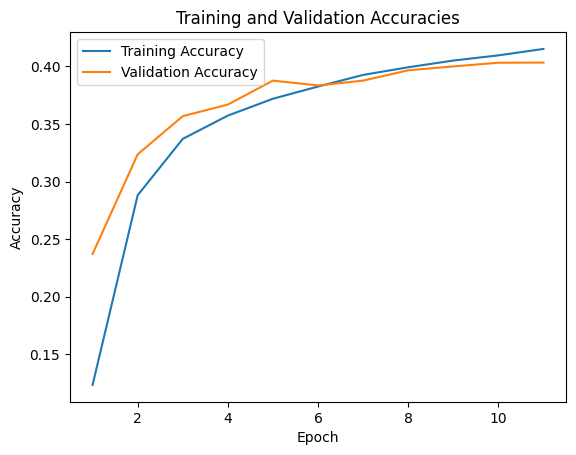

In [176]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

**[5.2]** Let's plot the training and validation losses

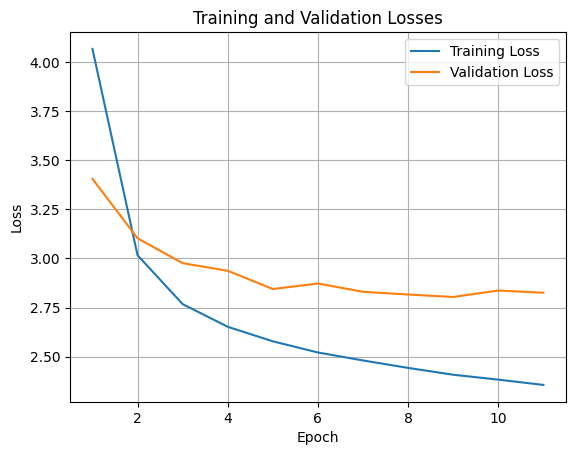

In [177]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

In [178]:
# Save the entire model
torch.save(nasnet_model, 'nasnet_model.pth')
